In [2]:
import pandas as pd
import numpy as np
import re
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\falou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\falou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('../data/consumer-complaint-database.csv')

C:\Users\falou\AppData\Local\Temp\ipykernel_4156\1681088808.py:1: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/consumer-complaint-database.csv')


In [4]:
# Basic cleaning
df = df[['Product', 'Consumer complaint narrative']].dropna()
df.columns = ['Product', 'Narrative']

print(df.head())
print(f"Data loaded: {df.shape}")
print(f"Classes: {df['Product'].unique()}")

                                                 Product  \
29904  Credit reporting, credit repair services, or o...   
30629  Credit reporting, credit repair services, or o...   
30735  Credit reporting, credit repair services, or o...   
30795  Credit reporting, credit repair services, or o...   
30807  Credit reporting, credit repair services, or o...   

                                               Narrative  
29904  The Summer of XX/XX/2018 I was denied a mortga...  
30629  There are many mistakes appear in my report wi...  
30735  There are many mistakes appear in my report wi...  
30795  There are many mistakes appear in my report wi...  
30807  There are many mistakes appear in my report wi...  
Data loaded: (383564, 2)
Classes: ['Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Student loan' 'Mortgage' 'Credit card or prepaid card'
 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Vehicle l

In [5]:
# I've decided to gather some categories to balance their sizes
category_mapping = {
    # 1. cards
    'Credit card': 'Credit card or prepaid card',
    'Prepaid card': 'Credit card or prepaid card',
    
    # 2. bank
    'Bank account or service': 'Checking or savings account',
    
    # 3. loans
    'Payday loan': 'Payday loan, title loan, or personal loan',
    'Consumer Loan': 'Payday loan, title loan, or personal loan',
    'Title loan': 'Payday loan, title loan, or personal loan',
    
    # 4. credit reporting
    'Credit reporting': 'Credit reporting, credit repair services, or other personal consumer reports',
    
    # 5. money transfers
    'Money transfers': 'Money transfer, virtual currency, or money service',
    'Virtual currency': 'Money transfer, virtual currency, or money service'
}

print("similar categories fusion :")
df['Product'] = df['Product'].replace(category_mapping)

print("\nNew enhanced categories:")
print(df['Product'].value_counts())

similar categories fusion :

New enhanced categories:
Product
Credit reporting, credit repair services, or other personal consumer reports    123966
Debt collection                                                                  86710
Mortgage                                                                         52987
Credit card or prepaid card                                                      41667
Checking or savings account                                                      27766
Student loan                                                                     21810
Payday loan, title loan, or personal loan                                        15642
Money transfer, virtual currency, or money service                                6979
Vehicle loan or lease                                                             5745
Other financial service                                                            292
Name: count, dtype: int64


In [6]:
df = df[df['Product'] != 'Other financial service']

print(df['Product'].value_counts())

Product
Credit reporting, credit repair services, or other personal consumer reports    123966
Debt collection                                                                  86710
Mortgage                                                                         52987
Credit card or prepaid card                                                      41667
Checking or savings account                                                      27766
Student loan                                                                     21810
Payday loan, title loan, or personal loan                                        15642
Money transfer, virtual currency, or money service                                6979
Vehicle loan or lease                                                             5745
Name: count, dtype: int64


In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans the raw text:
    1. Removes 'XXXX' masks
    2. Removes punctuation/numbers
    3. Lemmatizes and removes stopwords
    4. Truncates to 500 words (mostly to save compute time, and not to add noise (may change))
    """
    if not isinstance(text, str):
        return ""
    
    # 1. Remove masks (XXXX)
    text = re.sub(r'X+', '', text)
    
    # 2. Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 3. Lowercase
    text = text.lower()
    
    # 4. Tokenize
    tokens = text.split()
    
    # 5. Lemmatize & Remove Stopwords
    clean_tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    
    # 6. Truncate (keep first 500 words)
    clean_tokens = clean_tokens[:500]
    
    return " ".join(clean_tokens)



In [18]:
df['clean_text'] = df['Narrative'].apply(clean_text)

# Split Data
# stratify=y is mandatory here because of class imbalance
X = df['clean_text']
y = df['Product']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Training shapes: X=(306617,), y=(306617,)
Test shapes: X=(76655,), y=(76655,)


In [19]:
# Define the Pipeline: Vectorizer + Classifier
nlp_pipeline = Pipeline([
    # Step 1: Text to Numbers
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),  # Unigrams and Bigrams
        min_df=5,            # Ignore extremely rare words
        max_df=0.9,          # Ignore extremely common words
        max_features=10000,  # Limit vocabulary size
        stop_words='english'
    )),
    
    # Step 2: Classification Model
    ('clf', LogisticRegression(
        class_weight='balanced', # Handle class imbalance
        solver='liblinear',      # Optimized for high-dimensional data
        max_iter=1000            # Allow convergence
    ))
])

In [20]:
# Train the model
print("Training the model (this may take a moment)...")
nlp_pipeline.fit(X_train, y_train)
print("Training complete.")

Training the model (this may take a moment)...


c:\Users\falou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

--- Classification Report ---

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.80      0.83      0.81      5553
                                                 Credit card or prepaid card       0.79      0.83      0.81      8334
Credit reporting, credit repair services, or other personal consumer reports       0.90      0.83      0.86     24793
                                                             Debt collection       0.84      0.83      0.83     17342
                          Money transfer, virtual currency, or money service       0.69      0.78      0.73      1396
                                                                    Mortgage       0.92      0.93      0.93     10598
                                   Payday loan, title loan, or personal loan       0.53      0.53      0.53      3128
                        

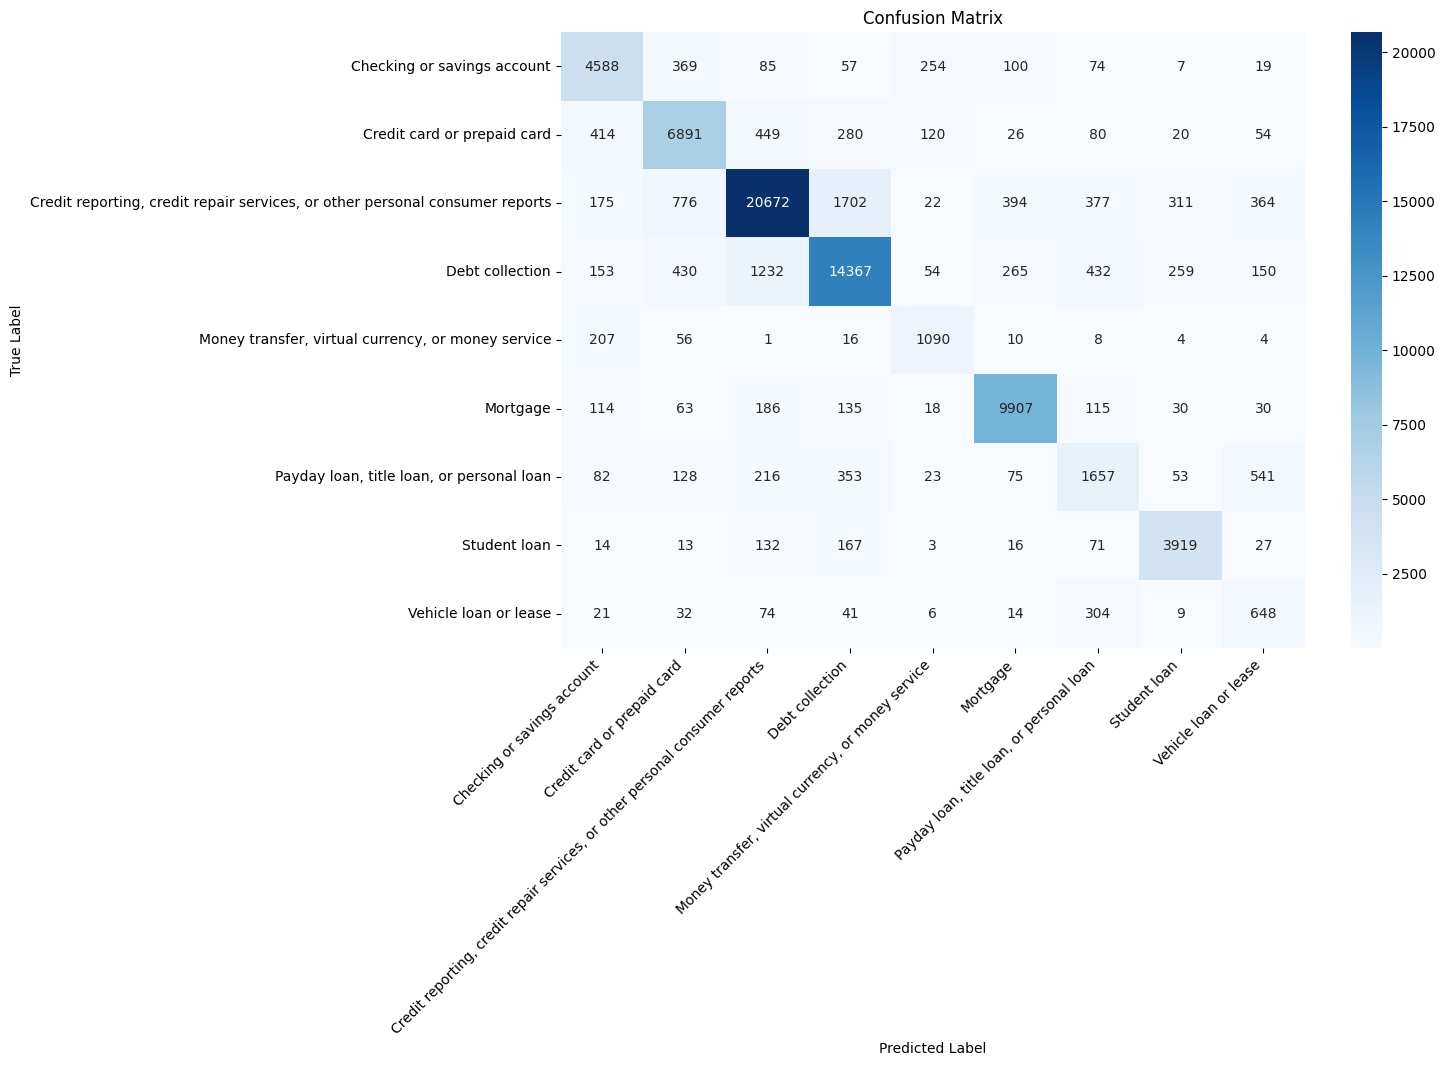

In [11]:
# Predictions
y_pred = nlp_pipeline.predict(X_test)

# Metrics
print("--- Classification Report ---\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nlp_pipeline.classes_,
            yticklabels=nlp_pipeline.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.show()

In [12]:
# Pick a specific index to inspect (e.g., 42)
idx = 42

# --- STEP 1: RAW DATA ---
raw_complaint = df.iloc[idx]['Narrative']
label_real = df.iloc[idx]['Product']

print(f"--- 1. RAW TEXT (True Label: {label_real}) ---")
print(f"Original: {raw_complaint[:200]}") # Display first 200 chars

# --- STEP 2: PREPROCESSING ---
# Apply the exact same function used during training
cleaned_complaint = clean_text(raw_complaint)

print(f"\n--- 2. CLEANED TEXT (Input for Pipeline) ---")
print(f"Cleaned:  {cleaned_complaint[:200]}")

# --- STEP 3: VECTORIZATION (TF-IDF) ---
# Retrieve the trained vectorizer from the pipeline steps
vectorizer = nlp_pipeline.named_steps['tfidf']

# Transform the cleaned text into a numeric vector
# Note: .transform() expects a list, hence [cleaned_complaint]
vector_representation = vectorizer.transform([cleaned_complaint])

print(f"\n--- 3. VECTOR REPRESENTATION (What the model sees) ---")
print(f"Matrix Shape: {vector_representation.shape}")
# Shape (1, N) means: 1 document, N features (total vocabulary size)

# Extract and sort features by their TF-IDF score (highest relevance first)
feature_names = vectorizer.get_feature_names_out()
sorted_items = sorted(zip(vector_representation.indices, vector_representation.data), 
                      key=lambda x: x[1], reverse=True)

print("\nTop 10 Activated Features (Words with highest TF-IDF scores):")
for idx_feat, score in sorted_items[:10]:
    word = feature_names[idx_feat]
    print(f"  - Word: '{word}' \t(ID: {idx_feat}) \tScore: {score:.4f}")

# --- STEP 4: PREDICTION (Logistic Regression) ---
# Retrieve the trained classifier
model = nlp_pipeline.named_steps['clf']

# Make prediction based on the vector
prediction = model.predict(vector_representation)[0]
probas = model.predict_proba(vector_representation)[0]

print(f"\n--- 4. MODEL PREDICTION ---")
print(f"Predicted Class: {prediction}")
print("Confidence Levels:")
for class_name, prob in zip(model.classes_, probas):
    # Display probability as percentage
    print(f"  - {class_name}: {prob:.2%}")

--- 1. RAW TEXT (True Label: Credit reporting, credit repair services, or other personal consumer reports) ---
Original: There are many mistakes appear in my report without my understanding.

--- 2. CLEANED TEXT (Input for Pipeline) ---
Cleaned:  many mistake appear report without understanding

--- 3. VECTOR REPRESENTATION (What the model sees) ---
Matrix Shape: (1, 10000)

Top 10 Activated Features (Words with highest TF-IDF scores):
  - Word: 'mistake appear' 	(ID: 5512) 	Score: 0.4706
  - Word: 'report understanding' 	(ID: 7670) 	Score: 0.4634
  - Word: 'appear report' 	(ID: 641) 	Score: 0.4615
  - Word: 'understanding' 	(ID: 9467) 	Score: 0.3498
  - Word: 'appear' 	(ID: 638) 	Score: 0.3446
  - Word: 'mistake' 	(ID: 5511) 	Score: 0.3020
  - Word: 'report' 	(ID: 7544) 	Score: 0.1360

--- 4. MODEL PREDICTION ---
Predicted Class: Credit reporting, credit repair services, or other personal consumer reports
Confidence Levels:
  - Checking or savings account: 0.34%
  - Credit card or pre

Training the improved model (LinearSVC + Char N-grams)...
Training complete.
Predicting on test set...

--- NEW Classification Report ---
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.78      0.81      0.79      5553
                                                 Credit card or prepaid card       0.78      0.81      0.80      8334
Credit reporting, credit repair services, or other personal consumer reports       0.90      0.85      0.87     24793
                                                             Debt collection       0.84      0.83      0.83     17342
                          Money transfer, virtual currency, or money service       0.69      0.76      0.72      1396
                                                                    Mortgage       0.91      0.93      0.92     10598
                                   

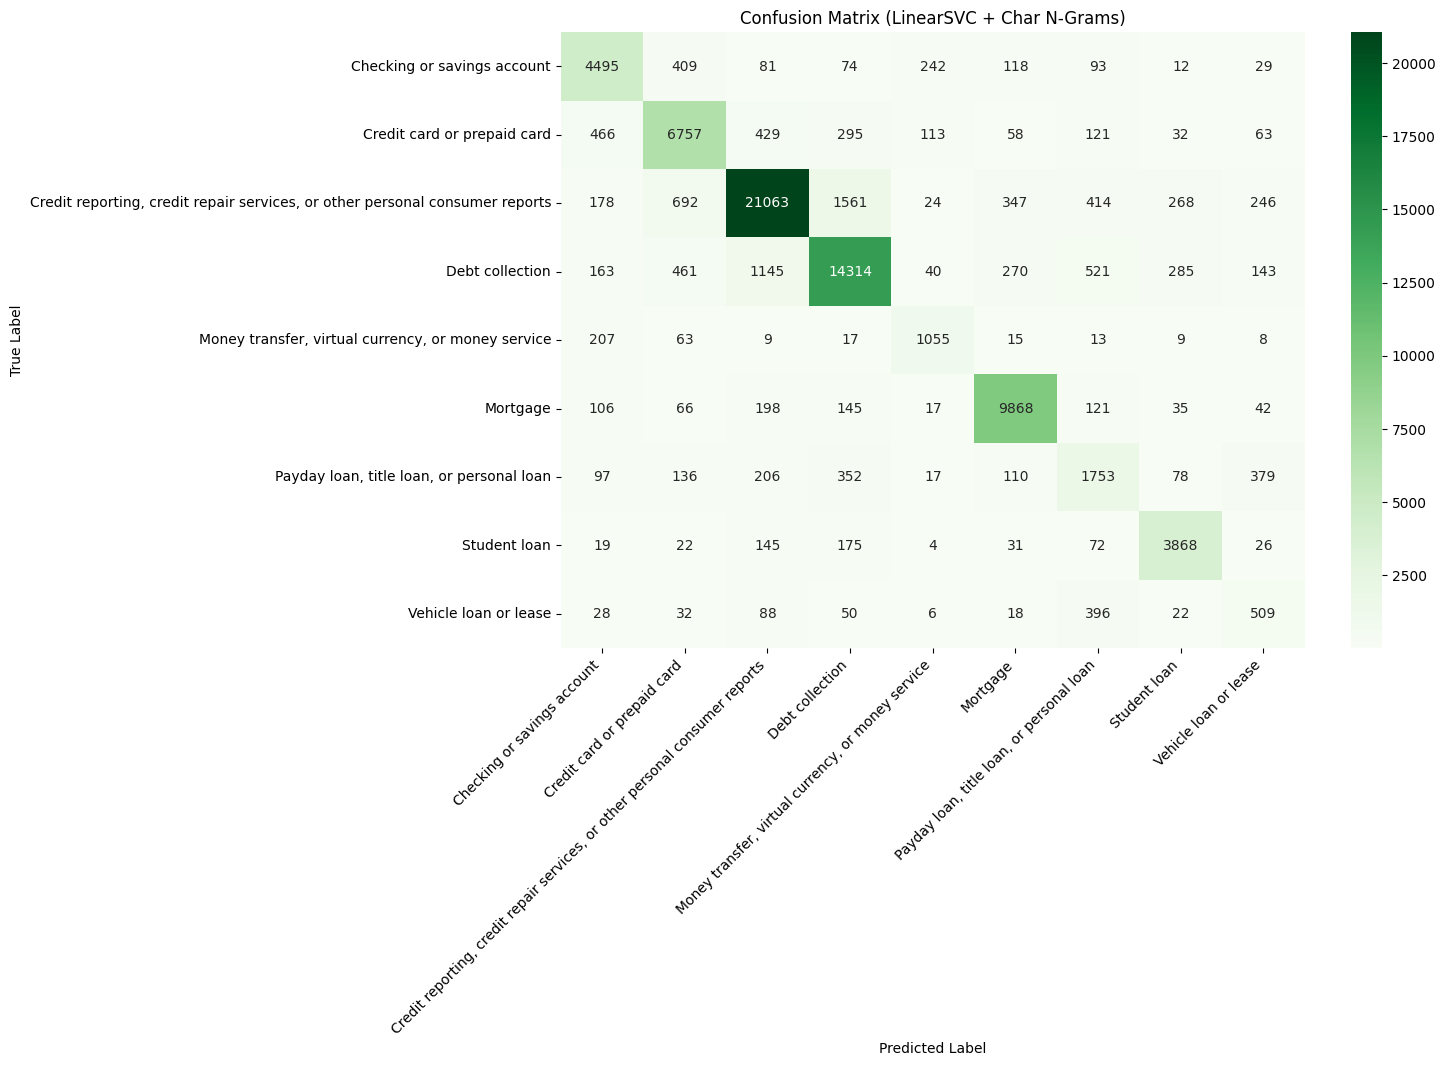

In [ ]:
 
from sklearn.svm import LinearSVC

nlp_pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(  
        ngram_range=(1, 2),
        min_df=5,            # Ignore patterns that appear less than 5 times
        max_df=0.9,          # Ignore patterns that appear in 90% of docs
        max_features=20000,  # Increased features size for char n-grams
    )),
    ('clf', LinearSVC(
        class_weight='balanced', # Force model to pay attention to small classes (Vehicle loan)
        random_state=42,
        max_iter=10000           # SVM needs more iterations to converge
    ))
])

# --- 3. TRAINING ---
print("Training the improved model (LinearSVC + Char N-grams)...")
# Note: This might take a bit longer than Logistic Regression
nlp_pipeline_svc.fit(X_train, y_train)
print("Training complete.")

# --- 4. EVALUATION ---
print("Predicting on test set...")
y_pred = nlp_pipeline_svc.predict(X_test)

print("\n--- NEW Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Green for improvement!
            xticklabels=nlp_pipeline.classes_,
            yticklabels=nlp_pipeline.classes_)
plt.title('Confusion Matrix (LinearSVC + Char N-Grams)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# # TRYING TO IMPROVE THE SCORE OF THE SMALLEST CLASS : VEHICLE LOAN OR LEASE

# # Specific keywords that strongly suggest a vehicle-related context.
# # We include brands, technical terms, and specific situations.
# vehicle_keywords = [
#     # Top car brands in the US
#     'toyota', 'honda', 'ford', 'chevrolet', 'chevy', 'nissan', 'jeep', 
#     'hyundai', 'kia', 'bmw', 'mercedes', 'volkswagen', 'vw', 'audi', 
#     'lexus', 'subaru', 'dodge', 'chrysler', 'gm', 'gmc', 'tesla',
#     # Technical terms
#     'dealership', 'dealer', 'lease', 'leasing', 'odometer', 'mileage', 
#     'vin', 'vehicle', 'truck', 'sedan', 'suv', 'coupe', 'hybrid', 
#     'motor', 'engine', 'auto loan', 'car loan',
#     # Specific situations
#     'repo', 'repossession', 'repossessed', 'tow', 'towed', 'towing', 
#     'gap insurance', 'wear and tear'
# ]

# # Compile regex for speed (r'\b' ensures we match whole words only, e.g., not "vin" in "having")
# vehicle_pattern = re.compile(r'\b(' + '|'.join(vehicle_keywords) + r')\b', re.IGNORECASE)

# # --- 2. BOOSTING FUNCTION ---
# def clean_and_boost_text(text):
#     """
#     1. Detects vehicle keywords in the RAW text (to catch typos/brands before cleaning).
#     2. Cleans the text using standard logic.
#     3. Injects a strong artificial signal if keywords were found.
#     """
#     if not isinstance(text, str): 
#         return ""
    
#     # Check for keywords in raw text
#     has_vehicle_context = bool(vehicle_pattern.search(text))
    
#     # Apply standard cleaning (ensure 'clean_text' function from previous cells is available)
#     processed_text = clean_text(text) 
    
#     if has_vehicle_context:
#         # INJECT THE SIGNAL
#         # Repeating it ensures high TF (Term Frequency) for the model
#         processed_text += " __VEHICLE_SIGNAL__ __VEHICLE_SIGNAL__ __VEHICLE_SIGNAL__"
        
#     return processed_text


In [ ]:
# # --- 3. APPLY AND SPLIT ---
# print("Enriching data with vehicle signal...")
# # Create a new column with the boosted text
# df['clean_text_boosted'] = df['Narrative'].apply(clean_and_boost_text)

Enriching data with vehicle signal...


In [ ]:
# # On dit à Pandas d'arrêter de couper les colonnes
# pd.set_option('display.max_colwidth', None)

# # On affiche les 5 premières lignes qui ont le signal
# print(df[df['clean_text_boosted'].str.contains('__VEHICLE_SIGNAL__')].head(5)['clean_text_boosted'])



31078                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
# # Visual check of the boosting
# print("Example of boosted text:")
# example_boosted = df[df['clean_text_boosted'].str.contains('__VEHICLE_SIGNAL__')].iloc[0]['clean_text_boosted']
# print(f"{example_boosted[:100]}...")

# # Define X and y with the new boosted text
# X_boosted = df['clean_text_boosted']
# y = df['Product']

# # Re-split the data (stratify is crucial here)
# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
#     X_boosted, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 4. RETRAIN MODEL ---
# print("\nRetraining LinearSVC pipeline on boosted data...")
# # We use the same 'nlp_pipeline' defined previously (LinearSVC + Char N-grams)
# nlp_pipeline.fit(X_train_b, y_train_b)
# print("Training complete.")

# # --- 5. EVALUATE ---
# print("\n--- NEW CLASSIFICATION REPORT (With Keyword Injection) ---")
# y_pred_b = nlp_pipeline.predict(X_test_b)
# print(classification_report(y_test_b, y_pred_b))

Example of boosted text:
account reporting credit report saying balance coming never signed joint lease anyone asked several ...

Retraining LinearSVC pipeline on boosted data...


c:\Users\falou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training complete.

--- NEW CLASSIFICATION REPORT (With Keyword Injection) ---
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.80      0.83      0.81      5553
                                                 Credit card or prepaid card       0.79      0.83      0.81      8334
Credit reporting, credit repair services, or other personal consumer reports       0.90      0.83      0.86     24793
                                                             Debt collection       0.84      0.83      0.83     17342
                          Money transfer, virtual currency, or money service       0.69      0.78      0.73      1396
                                                                    Mortgage       0.92      0.94      0.93     10598
                                   Payday loan, title loan, or personal loan       0.53      0

In [ ]:
## CONCLUSION : Doesn't work at all, useless

## Final model selection : tf-idf + Ngrams (1,2) + RegLog

In [21]:
import joblib
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# --- 1. DATA PREPARATION (Standard Version) ---
# We use the standard 'clean_text' column, NOT the boosted one.
# This ensures the model is standalone and easy to deploy.
X = df['clean_text']
y = df['Product']

# Split (Same random_state to ensure consistency with your exploration)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 2. DEFINE BASIC PIPELINE ---
# We return to the robust baseline: TF-IDF + Logistic Regression
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000, 
        ngram_range=(1, 2), 
        stop_words='english',
        min_df=5
    )),
    ('clf', LogisticRegression(
        class_weight='balanced', # Handles the imbalance nicely
        solver='liblinear',
        random_state=42,
        max_iter=1000
    ))
])

# --- 3. TRAIN ---
print("Training the final Logistic Regression model...")
final_pipeline.fit(X_train, y_train)
print("Training complete.")

# --- 4. SAVE MODEL ---
# Create 'models' directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

model_path = '../models/nlp_classifier.pkl'
joblib.dump(final_pipeline, model_path)

print(f" Basic model saved successfully to: {model_path}")

Training the final Logistic Regression model...


c:\Users\falou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training complete.
 Basic model saved successfully to: ../models/nlp_classifier.pkl
